<a href="https://colab.research.google.com/github/renatoquiliche/DataScience-PUCRio-FB/blob/main/Task%202/Evaluation/Leonardo_Rafael.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
install.packages('rpart.plot')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [20]:
library(readr)
library(caret)
library(rpart)
library(rpart.plot)
library(mltools)
library(dplyr)

In [21]:
# Lendo os dados
salarios.c <- read.csv("https://raw.githubusercontent.com/renatoquiliche/DataScience-PUCRio-FB/main/Data/DS_salarios/ds_salaries.csv")[,-1]


In [22]:
#### Pre-Processamento
### Exercicio 1 
# Transformando as variáveis categoricas em dummies exceto a variavel alvo "company_size"
str(salarios.c)
salarios.c$work_year <- as.character(salarios.c$work_year)
salarios.c$work_month <- as.character(salarios.c$work_month)
salarios.c$remote_ratio <- as.character(salarios.c$remote_ratio)
salarios.c$company_size <- factor(salarios.c$company_size)


dummies <- dummyVars(salary_in_usd ~ work_year + work_month + experience_level + employment_type + 
                       job_title + salary_currency + employee_residence + remote_ratio + 
                       company_location, data = salarios.c, fullRank = T)

# É utilizado fullRank = T para evitar existencia de variáveis com colinearidade perfeita no modelo
dummies <- predict(dummies,newdata=salarios.c)
salarios <- cbind(salarios.c,dummies)
salarios <- salarios[,-c(1,2,3,4,5,7,9,10,11)]
colnames(salarios) <- gsub(" ", "\\_", colnames(salarios))


# Criar amostras treino/teste
set.seed(400)
inTrain <- createDataPartition(y=salarios$company_size,p=0.80,list=F)
train <- salarios[inTrain,]
test <- salarios[-inTrain,]

# Análise de variância, correlação e dependência linear
# NearZeroVar
nzv <- nearZeroVar(train, saveMetrics = F) 
train <- train[,-nzv]
# Removo 161 variaveis

'data.frame':	607 obs. of  12 variables:
 $ work_year         : int  2020 2020 2020 2020 2020 2020 2020 2020 2020 2020 ...
 $ work_month        : int  6 11 12 6 10 8 2 1 2 6 ...
 $ experience_level  : chr  "MI" "SE" "SE" "MI" ...
 $ employment_type   : chr  "FT" "FT" "FT" "FT" ...
 $ job_title         : chr  "Data Scientist" "Machine Learning Scientist" "Big Data Engineer" "Product Data Analyst" ...
 $ salary            : int  70000 260000 85000 20000 150000 72000 190000 11000000 135000 125000 ...
 $ salary_currency   : chr  "EUR" "USD" "GBP" "USD" ...
 $ salary_in_usd     : int  79833 260000 109024 20000 150000 72000 190000 35735 135000 125000 ...
 $ employee_residence: chr  "DE" "JP" "GB" "HN" ...
 $ remote_ratio      : int  0 0 50 0 50 100 100 50 100 50 ...
 $ company_location  : chr  "DE" "JP" "GB" "HN" ...
 $ company_size      : chr  "L" "S" "M" "S" ...


NULL

Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(variaveis_mantidas)

  # Now:
  data %>% select(all_of(variaveis_mantidas))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”


Confusion Matrix and Statistics

          Reference
Prediction  L  M  S
         L 29  8  2
         M  9 56  0
         S 11  4  1

Overall Statistics
                                          
               Accuracy : 0.7167          
                 95% CI : (0.6272, 0.7951)
    No Information Rate : 0.5667          
    P-Value [Acc > NIR] : 0.0005055       
                                          
                  Kappa : 0.4913          
                                          
 Mcnemar's Test P-Value : 0.0162583       

Statistics by Class:

                     Class: L Class: M Class: S
Sensitivity            0.5918   0.8235 0.333333
Specificity            0.8592   0.8269 0.871795
Pos Pred Value         0.7436   0.8615 0.062500
Neg Pred Value         0.7531   0.7818 0.980769
Prevalence             0.4083   0.5667 0.025000
Detection Rate         0.2417   0.4667 0.008333
Detection Prevalence   0.3250   0.5417 0.133333
Balanced Accuracy      0.7255   0.8252 0.602564

[1] 0.5010749

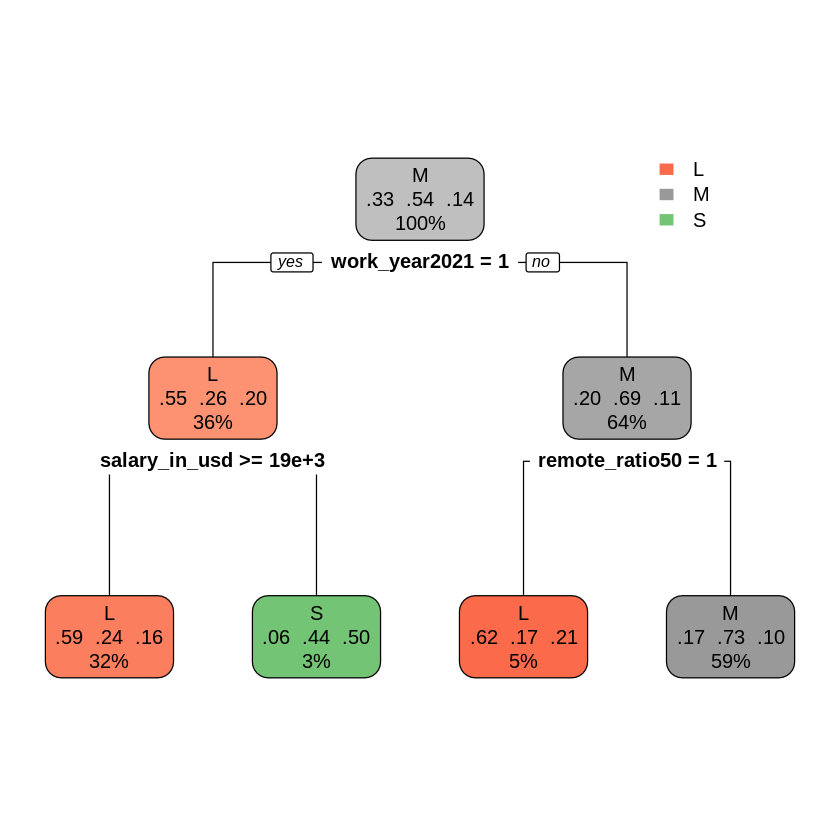

In [23]:
# Correlacao
corr <- cor(train[c(1:2,4:33)],method = "spearman") 
alta_corr <- findCorrelation(corr, cutoff = .75, names=T) 
train <- dplyr::select(train,- alta_corr)
# Removo 5 variaveis

# Dependencia Linear
dep_lin <- findLinearCombos(train[,c(1:2,4:28)])   
dep_lin$remove
# Como dep_lin$remove é NULL, nao removemos nenhuma variavel

# Variaveis que foram mantidas
variaveis_mantidas <- colnames(train)



#### Processamento
### Exercicio 2 
## 2.1)
fitree <- rpart(company_size~., data=train, maxdepth = 3)

## 2.2)
rpart.plot(fitree)


### Exercicio 3 
## 3.1)
# A raiz da árvore identifica se o ano de trabalho é 2021 ou não. Se o ano for 2021, o nó subsequente identifica se o salário em dólares é maior ou igual a $19,000.00. Caso positivo, a folha é formada por 32% dos trabalhadores, sendo desses 59% de empresa L, 24% de M e 16% de empresa S. Se não for, a folha conclui que há somente 3% das pessoas nesta categoria, sendo 6% de empresa L, 44% de M e 50% de empresa S. Voltando ao primeiro nó, oriundo da raiz da árvore, caso o ano de trabalho seja 2020 ou 2022, o nó inclui a condição se ele trabalha parcialmente remoto ou não. Se sim, ele conclui que essa folha é formada por apenas 5% dos trabalhadores, sendo desses 62% de empresa L, 17% de empresa M e 21% de empresa S. Para o caso de não se trabalhar parcialmente remoto, a folha é formada por 59% das pessoas, sendo destes 17% de empresa L, 73% de M e 10% de empresa S. 


#### Pos-Processamento
### Exercicio 4 
## 4.1) Removendo as mesmas variaveis removidas na amostra treino
test <- dplyr::select(test, variaveis_mantidas)
# 4.1.1)
estimate <- predict(fitree, test, type = "class")
confusionMatrix(test$company_size, estimate)
# A partir da matriz de confusão, obteve-se uma acurácia de 71,67% para o modelo, um resultado satisfatório. Para empresas pequenas, pode-se concluir pela matriz que ela acertou a previsão em somente 1 dos 3 casos, tendo 2 como grandes. Para a previsão de empresas médias, a árvore operou bem melhor, prevendo 56 de 68 como médias, 4 como pequenas e 8 como grandes. Já para empresas grandes, de 49 empresas deste tamanho, ela categorizou 29 corretamente e 20 erroneamente, sendo 11 pequenas e 9 médias. 

# 4.1.2)
mcc(test$company_size,estimate)
# Foi obtido para o modelo um valor de MCC = 0,5. Este índice varia de -1 a 1, quanto mais próximo de 1, melhor o modelo, portanto pode-se considerar um bom valor.